# Introduction

This is the validation notebook for the PySAL implementation of the local join count (LJC) multivariate statistic. This notebook will begin with a brief review of the multivariate LJC and a manual calculation of the values on a 'toy' dataset. We will then introduce the PySAL implementation of the `Local_Join_Count_MV` function. Output from the `Local_Join_Count_MV` function will be compared to the results from the manual calculation on the 'toy' dataset. Following the 'toy' dataset will be a comparison of the PySAL `Local_Join_Count_MV` function to the external `GeoDa` results on an external dataset. As of now, calculations of inference are not included in the function.

1. [Review of the bivariate LJC statistic](#Review)
2. [Manual calculations on a 'toy' dataset](#Toy)
3. [Implementation of Local_Join_Count_MV function](#LJC)
4. [Application of Local_Join_Count_MV function on the 'toy' dataset](#LJCToy)
5. [Application of Local_Join_Count_MV function on 'real world' datasets](#LJCRealWorld)

## Review of the multivariate LJC statistic <a name="Review"></a>

Multivariate local join counts, at least those laid out in Anselin and Li 2019, is an expansion of the bivariate local join count statistic (case 2) for co-location clusters. Formally:

$$ CLC_i = \Pi^m_{h=1} x_{hi} \sum_j w_{ij} \Pi^m_{h=1} x_{hj} $$

## Manual calculations on a 'toy' dataset <a name="Toy"></a>

For the multivariate test, let's consider the variables `x`, `z`, and a new third variable called `y`. We now create a small 'toy' dataset to illustrate the local join counts. This toy dataset is a 4x4 lattice grid filled with 0s and 1s for each of the x, z, y binary variables. Note that for a given cell, the value of the x variable comes first, the value of the z variable comes second, and the value of the y variable comes third. 

|   |   |   |   |
|---|---|---|---|
| 0,0,0 | 0,1,1 | 0,0,1 | 0,1,1 |
| 0,1,1 | 0,1,1 | 0,1,1 | 0,1,1 |
| 1,0,0 | 1,0,0 | 1,1,0 | 1,1,1 |
| 1,0,0 | 1,0,0 | 1,1,1 | 1,1,1 |

The arrangement of the above grid is captured in the `x`, `z`, and `y` objects below.

In [1]:
import numpy as np
import libpysal
import pandas as pd

# Create a 16x16 grid
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
x = x.astype(np.int32)
# Create another random sequences of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
y = [0,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1]
print('x', x)
print('z', z)
print('y', y)

x [0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
z [0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
y [0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1]


For a given cell of the above table, we are interest in the adjacent grid cells that are equal to 1. We can find these through the use of **binary weights**. 

In [2]:
# Flatten the input vector y
x = np.asarray(x).flatten()
z = np.asarray(z).flatten()
y = np.asarray(y).flatten()
print(x)
print(z)
print(y)
# ensure weights are binary transformed
w.transform = 'b'

[0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
[0 1 0 1 1 1 1 1 0 0 1 1 0 0 1 1]
[0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1]


How does PySAL identify these cells? Through an adjacency list. This creates a list object of unique focal ($i$) and neighbor ($j$) pairs. The `remove_symmetric=True` ensure that there are not duplicated (but reversed) adjacency pairs. This is a great shortcut when calculating global join counts.

In [3]:
adj_list = w.to_adjlist(remove_symmetric=True) 
print(adj_list)
print(w[0])

    focal  neighbor  weight
1       0         1     1.0
3       1         5     1.0
5       2         1     1.0
7       2         3     1.0
10      4         0     1.0
12      4         5     1.0
16      5         6     1.0
17      6         2     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
27      9         5     1.0
28      9         8     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11     1.0
37     11        15     1.0
39     12        13     1.0
40     13         9     1.0
44     14        13     1.0
45     14        15     1.0
{4: 1.0, 1: 1.0}


From this list we can validate neighbors. For example, in our 4x4 grid, we know that the upper-left hand corner of the grid (w[0]) only touches its right and bottom neighbor(remember: we are not using a queen contiguity in this example). Thus, the first weight object will capture these relationships and they will be reflected in the adj_list table (see row 1 [0 1 1.0] and 4 [4 0 1.0]). 

**However, the Local Join Count (LJC) statistics do not use the `remove_symmetric=True`.** This allows us to identify the specific join counts for each area $i$.

In [4]:
adj_list = w.to_adjlist(remove_symmetric=False) 
print(adj_list)

    focal  neighbor  weight
0       0         4     1.0
1       0         1     1.0
2       1         0     1.0
3       1         5     1.0
4       1         2     1.0
5       2         1     1.0
6       2         6     1.0
7       2         3     1.0
8       3         2     1.0
9       3         7     1.0
10      4         0     1.0
11      4         8     1.0
12      4         5     1.0
13      5         1     1.0
14      5         4     1.0
15      5         9     1.0
16      5         6     1.0
17      6         2     1.0
18      6         5     1.0
19      6        10     1.0
20      6         7     1.0
21      7         3     1.0
22      7         6     1.0
23      7        11     1.0
24      8         4     1.0
25      8        12     1.0
26      8         9     1.0
27      9         5     1.0
28      9         8     1.0
29      9        13     1.0
30      9        10     1.0
31     10         6     1.0
32     10         9     1.0
33     10        14     1.0
34     10        11 

We now mirror the existing implementation of `Join_Counts` to create some objects that count the number of 1 value for the focal ($i$) and neighbor ($j$) cells. We do this for both the x, z, and y variables. **Note: perhaps an area for optimization?**

In [5]:
variables = [x,y,z]
# The zseries
zseries = [pd.Series(i, index=w.id_order) for i in variables]
# The focal values
focal = np.array([zseries[i].loc[adj_list.focal].values for i in range(len(variables))])
# The neighbor values
neighbor = np.array([zseries[i].loc[adj_list.neighbor].values for i in range(len(variables))])

Print out the results and manually validate!

In [6]:
print(zseries)
print(focal)
print(neighbor)

[0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
dtype: int32, 0     0
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     0
9     0
10    0
11    1
12    0
13    0
14    1
15    1
dtype: int32, 0     0
1     1
2     0
3     1
4     1
5     1
6     1
7     1
8     0
9     0
10    1
11    1
12    0
13    0
14    1
15    1
dtype: int32]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
  1 1 0 0 0 0 0 1 1 1 1 1]
 [0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1
  1 1 0 0 0 0 0 1 1 1 1 1]]
[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 1 1 1 0
  1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1
  0 1 0 0 0 0 1 0 0 1 1 1]
 [1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0

Now comes the most important part, we need to expand the following function to as many variables are input. For former co-location cluster (CLC) now becomes the multivariate co-location cluster (MCLC):

`MCLC = (focal_x == 1) & (focal_z == 1) & (focal_y == 1) & (neighbor_x == 1) & (neighbor_z == 1) & (neighbor_y == 1) & 
... (focal_m == 1) & (neighbor_m == 1)`

From this point we need to do a bit of code golf. We have a list-of-lists and we need to check to make sure that the vlaues across all the lists have the value of interest (1). Thus, we can combine the `np.all()` function with an `np.dstack()==1` conditional function. This does scalable, row-wise evaluation to find rows where all are equal to True (i.e. all values equal 1).

In [7]:
focal_all = np.all(np.dstack(focal)==1, axis=2)
neighbor_all = np.all(np.dstack(neighbor)==1, axis=2)
print(focal_all)
print(neighbor_all)

[[False False False False False False False False False False False False
  False False False False False False False False False False False False
  False False False False False False False False False False False  True
   True  True False False False False False  True  True  True  True  True]]
[[False False False False False False False False False False False False
  False False False False False False False False False False False  True
  False False False False False False False False False  True  True False
  False  True False False False False  True False False  True  True  True]]


Now we can return to the original implementation of `CLC` and identify those that are both 1...

In [8]:
MCLC = (focal_all == True) & (neighbor_all == True)
# Convert to boolean array
MCLC = list(MCLC*1)
MCLC

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1])]

In [9]:
# Create a df that uses the adjacency list focal values and the BBs counts
manual = pd.DataFrame(adj_list.focal.values, MCLC).reset_index()
# Temporarily rename the columns
manual.columns = ['MCLC', 'ID']
manual = manual.groupby(by='ID').sum()
manual.MCLC.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2], dtype=int64)

Let's do a visual comparison to the original table (remember, x values appear first and z values appear second):

Original table


|   |   |   |   |
|---|---|---|---|
| 0,0,0 | 0,1,1 | 0,0,1 | 0,1,1 |
| 0,1,1 | 0,1,1 | 0,1,1 | 0,1,1 |
| 1,0,0 | 1,0,0 | 1,1,0 | 1,1,1 |
| 1,0,0 | 1,0,0 | 1,1,1 | 1,1,1 |


Local Join Counts (multivariate)

|   |   |   |   |
|---|---|---|---|
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 0 |
| 0 | 0 | 0 | 1 |
| 0 | 0 | 1 | 2 |

This makes sense give our previously stated CLC conditions!

## Implementation of Local_Join_Count_MV function <a name="LJC"></a>

The above manual calculations are implemented in the function called `Local_Join_Count_MV`. We run an ongoing notebook where the functions are being developed. Note that the below is likely to change over time. The following cell loads in the `Local_Join_Count_MV` function from the `migration.ipynb` (available on the [jeffcsauer/GSOC2020/scratch](https://github.com/jeffcsauer/GSOC2020/tree/master/scratch) github work journal. 

In [10]:
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.base import BaseEstimator
from libpysal import weights

PERMUTATIONS = 999

class Local_Join_Count_MV(BaseEstimator):

    """Multivariate local join counts"""

    def __init__(self, connectivity=None, permutations=PERMUTATIONS):
        """
        Initialize a Local_Join_Count_MV estimator
        Arguments
        ---------
        connectivity:   scipy.sparse matrix object
                        the connectivity structure describing the relationships
                        between observed units. Will be row-standardized.
        Attributes
        ----------
        LJC       :   numpy.ndarray
                      array containing the estimated Multivariate Local Join Counts.
        p_sim       :   numpy.ndarray
                        array containing the simulated p-values for each unit.
        """

        self.connectivity = connectivity
        self.permutations = permutations

    def fit(self, variables, permutations=999):
        """
        Arguments
        ---------
        variables     :   numpy.ndarray
                          array(s) containing binary (0/1) data
        Returns
        -------
        the fitted estimator.
        Notes
        -----
        Technical details and derivations can be found in :cite:`AnselinLi2019`.
        """

        w = self.connectivity
        # Fill the diagonal with 0s
        w = weights.util.fill_diagonal(w, val=0)
        w.transform = 'b'
        
        self.n = len(variables[0])
        self.w = w
        
        self.variables = variables
        
        self.ext = np.prod(np.vstack(variables), axis=0)

        self.LJC = self._statistic(variables, w)
        
        if permutations:
            self._crand()
            sim = np.transpose(self.rjoins)
            above = sim >= self.LJC
            larger = above.sum(0)
            low_extreme = (self.permutations - larger) < larger
            larger[low_extreme] = self.permutations - larger[low_extreme]
            self.p_sim = (larger + 1.0) / (permutations + 1.0)
            # Set p-values for those with LJC of 0 to NaN
            self.p_sim[self.LJC==0] = 'NaN'

        return self

    @staticmethod
    def _statistic(variables, w):
        # Create adjacency list. Note that remove_symmetric=False -
        # different from the esda.Join_Counts() function.
        adj_list = w.to_adjlist(remove_symmetric=False)

        # The zseries
        zseries = [pd.Series(i, index=w.id_order) for i in variables]
        # The focal values
        focal = [zseries[i].loc[adj_list.focal].values for
                 i in range(len(variables))]
        # The neighbor values
        neighbor = [zseries[i].loc[adj_list.neighbor].values for
                    i in range(len(variables))]

        # Find instances where all surrounding 
        # focal and neighbor values == 1
        focal_all = np.array(np.all(np.dstack(focal)==1, 
                                    axis=2))
        neighbor_all = np.array(np.all(np.dstack(neighbor)==1, 
                                       axis=2))
        MCLC = (focal_all == True) & (neighbor_all == True)
        # Convert list of True/False to boolean array 
        # and unlist (necessary for building pd.DF)
        MCLC = list(MCLC*1)
        
        # Create a df that uses the adjacency list
        # focal values and the BBs counts
        adj_list_MCLC = pd.DataFrame(adj_list.focal.values,
                                     MCLC).reset_index()
        # Temporarily rename the columns
        adj_list_MCLC.columns = ['MCLC', 'ID']
        adj_list_MCLC = adj_list_MCLC.groupby(by='ID').sum()

        return (adj_list_MCLC.MCLC.values)
            
    def _crand(self):
        """
        conditional randomization

        for observation i with ni neighbors,  the candidate set cannot include
        i (we don't want i being a neighbor of i). we have to sample without
        replacement from a set of ids that doesn't include i. numpy doesn't
        directly support sampling wo replacement and it is expensive to
        implement this. instead we omit i from the original ids,  permute the
        ids and take the first ni elements of the permuted ids as the
        neighbors to i in each randomization.

        """
        # converted y to z
        # renamed lisas to joins
        ext = self.ext
        # Get length based on first variable
        n = len(ext)
        joins = np.zeros((self.n, self.permutations))
        n_1 = self.n - 1
        prange = list(range(self.permutations))
        k = self.w.max_neighbors + 1
        nn = self.n - 1
        rids = np.array([np.random.permutation(nn)[0:k] for i in prange])
        ids = np.arange(self.w.n)
        ido = self.w.id_order
        w = [self.w.weights[ido[i]] for i in ids]
        wc = [self.w.cardinalities[ido[i]] for i in ids]

        for i in range(self.w.n):
            idsi = ids[ids != i]
            np.random.shuffle(idsi)
            # Mirroring moran_local_bv()
            tmp = ext[idsi[rids[:, 0:wc[i]]]]
            joins[i] = ext[i] * (w[i] * tmp).sum(1)
        self.rjoins = joins

Inference not working at all - need to figure out how to scale for all input variables...

## Application of Local_Join_Count function on the 'toy' dataset <a name="LJCToy"></a>

In [11]:
# Recreate inputs and weights (otherwise they are altered when running notebook)
w = libpysal.weights.lat2W(4, 4)
y_1 = np.ones(16)
# Set the first 9 of the ones to 0
y_1[0:8] = 0
# Set x equal to y_1
x = y_1
x = x.astype(np.int32)
# Create another random sequences of 0 and 1
z = [0,1,0,1,1,1,1,1,0,0,1,1,0,0,1,1]
y = [0,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1]
# Run function
toy_results = Local_Join_Count_MV(connectivity=w).fit([x, y, z])
toy_results.LJC

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2], dtype=int64)

Compare output of `Local_Join_Count` function to the manually-calculated `LJC` from above.

In [12]:
print("Comparison of toy function to manual values")
print(toy_results.LJC == manual.MCLC.values)

Comparison of toy function to manual values
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


All values match.

## Application of Local_Join_Count_BV function on 'real world' datasets <a name="LJCRealWorld"></a>

Ideally, we would look to compare the output to the values from the original Anselin and Li 2019 paper. However, the example use cases in Anselin and Li 2019 do not provide full tables of LJC and associate p-values to confirm equivalency. Thus, we compare the results from the PySAL implementation of `Local_Join_Counts_MV` to the output from GeoDa using a GeoDa example dataset. Specifically, we use the [Baltimore Housing Sales dataset](https://geodacenter.github.io/data-and-lab/baltim/) and focus on the 'dwell', 'patio', and 'firepl' binary variables. 

### Comparison to GeoDa output

We first load in the Baltimore Housing Sales dataset.

In [13]:
import geopandas as gpd
balt = gpd.read_file('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/baltimore_housing.gpkg')
balt.head()

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,geometry
0,1.0,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,POINT (907.000 534.000)
1,2.0,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,POINT (922.000 574.000)
2,3.0,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,POINT (920.000 581.000)
3,4.0,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,POINT (923.000 578.000)
4,5.0,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,POINT (918.000 574.000)


Isolate the variable of interest.

In [14]:
x_balt = balt['dwell']
z_balt = balt['patio']
y_balt = balt['firepl']

x_balt = np.asarray(x_balt).flatten()
z_balt = np.asarray(z_balt).flatten()
y_balt = np.asarray(y_balt).flatten()

When working with points in PySAL we need to arrange them into a tree-able list of x and y points. Thus we extract the x and y columns of the baltimore dataset.

In [15]:
points = list(zip(balt['x'], balt['y']))
import libpysal
kd = libpysal.cg.KDTree(np.array(points))

We need to recreate the weights used in the GeoDa analysis. The weight scheme used was a k-nearest neighbor (knn) approach, using 5 neighbors.

In [16]:
balt_knn5 = libpysal.weights.KNN(kd, k=5) 

We can now apply our PySAL `Local_Join_Count_MV` function.

In [17]:
test_results = Local_Join_Count_MV(connectivity=balt_knn5).fit([x_balt, z_balt, y_balt])
test_results.LJC

array([0, 4, 5, 5, 3, 1, 4, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

Now let's read in the results from GeoDa analysis.

In [18]:
# Load GeoDa analysis results
GeoDa_LJC = pd.read_csv('https://github.com/jeffcsauer/GSOC2020/raw/master/validation/data/baltimore/balt_knn_5_LJC_multivariate.csv')
GeoDa_LJC.head(10)

,station,price,nroom,dwell,nbath,patio,firepl,ac,bment,nstor,gar,age,citcou,lotsz,sqft,x,y,MV_JC,MV_NN,MV_PP_VAL
0,1,47.0,4.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,0.0,148.0,0.0,5.70,11.25,907.0,534.0,0,5,NaN
1,2,113.0,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,9.0,1.0,279.51,28.92,922.0,574.0,4,5,0.001
2,3,165.0,7.0,1.0,2.5,1.0,1.0,0.0,3.0,2.0,2.0,23.0,1.0,70.64,30.62,920.0,581.0,5,5,0.001
3,4,104.3,7.0,1.0,2.5,1.0,1.0,1.0,2.0,2.0,2.0,5.0,1.0,174.63,26.12,923.0,578.0,5,5,0.001
4,5,62.5,7.0,1.0,1.5,1.0,1.0,0.0,2.0,2.0,0.0,19.0,1.0,107.80,22.04,918.0,574.0,3,5,0.007
5,6,70.0,6.0,1.0,2.5,1.0,1.0,0.0,3.0,3.0,1.0,20.0,1.0,139.64,39.42,900.0,577.0,1,5,0.274
6,7,127.5,6.0,1.0,2.5,1.0,1.0,1.0,3.0,1.0,2.0,20.0,1.0,250.00,21.88,918.0,576.0,4,5,0.001
7,8,53.0,8.0,1.0,1.5,1.0,0.0,0.0,0.0,3.0,0.0,22.0,1.0,100.00,36.72,907.0,576.0,0,5,NaN
8,9,64.5,6.0,1.0,1.0,1.0,1.0,1.0,3.0,2.0,0.0,22.0,1.0,115.90,25.60,918.0,562.0,0,5,NaN
9,10,145.0,7.0,1.0,2.5,1.0,1.0,1.0,3.0,2.0,2.0,4.0,1.0,365.07,44.12,897.0,576.0,1,5,0.274


Compare the PySAL LJC results to to the GeoDa LJC results. Due to the somewhat high (n=211) number of comparisons, we will tabulate the results.

In [19]:
print("Comparison of GeoDa multivariate LJC to PySAL implementation:")
results = test_results.LJC == GeoDa_LJC['MV_JC']
print(results.value_counts())

Comparison of GeoDa multivariate LJC to PySAL implementation:
True    211
Name: MV_JC, dtype: int64


All 211 elements have the same multivariate LJC between the PySAL implementation and the GeoDa results.

Comparing p-values at surface level...

In [20]:
test_results.p_sim[0:10]

array([  nan, 0.001, 0.001, 0.001, 0.003, 0.284, 0.001,   nan,   nan,
       0.291])

In [21]:
np.array(GeoDa_LJC.MV_PP_VAL[0:10])

array([  nan, 0.001, 0.001, 0.001, 0.007, 0.274, 0.001,   nan,   nan,
       0.274])

Differences in p-values...

In [22]:
test_results.p_sim[0:10] - np.array(GeoDa_LJC.MV_PP_VAL[0:10])

array([   nan,  0.   ,  0.   ,  0.   , -0.004,  0.01 ,  0.   ,    nan,
          nan,  0.017])

The correlation between the two sets of p-values is 0.9997319782770386


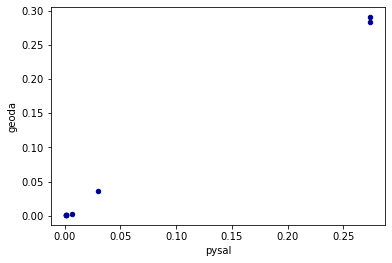

In [23]:
# Assess correlation between p-values
corrdf = pd.DataFrame(test_results.p_sim, GeoDa_LJC.MV_PP_VAL).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

# Next steps

- Ensure docstrings include all relevant information and formatting


# Quick comparison to [GeoDa Guerry Example](https://geodacenter.github.io/workbook/6b_local_adv/lab6b.html#bivariate-and-multivariate---co-location)

In [28]:
guerry = gpd.read_file('C:/Users/jeffe/Dropbox/GSOC2020/validation/data/guerry/guerry_geodavalues.gpkg')
guerry.head()

,POLY_ID,CODE_DE,COUNT,AVE_ID_,dept,Region,Dprtmnt,Crm_prs,Crm_prp,Litercy,...,Distanc,Area,Pop1831,INF,DON,SELECTED,JC_MV,NN_MV,PP_VAL_MV,geometry
0,1,01,1.0,49.0,1,E,Ain,28870,15890,37,...,218.372,5762,346.03,1,0,0,0,4,NaN,"MULTIPOLYGON (((801150.000 2092615.000, 800669..."
1,2,02,1.0,812.0,2,N,Aisne,26226,5521,51,...,65.945,7369,513.00,0,0,0,0,6,NaN,"MULTIPOLYGON (((729326.000 2521619.000, 729320..."
2,3,03,1.0,1418.0,3,C,Allier,26747,7925,13,...,161.927,7340,298.26,0,1,0,0,6,NaN,"MULTIPOLYGON (((710830.000 2137350.000, 711746..."
3,4,04,1.0,1603.0,4,E,Basses-Alpes,12935,7289,46,...,351.399,6925,155.90,0,0,0,0,4,NaN,"MULTIPOLYGON (((882701.000 1920024.000, 882408..."
4,5,05,1.0,1802.0,5,E,Hautes-Alpes,17488,8174,69,...,320.280,5549,129.10,0,0,0,0,3,NaN,"MULTIPOLYGON (((886504.000 1922890.000, 885733..."


In [39]:
from libpysal.weights import Queen
guerry_wq = Queen.from_dataframe(guerry)

Pass through function

In [40]:
guerry_results = Local_Join_Count_MV(connectivity=guerry_wq).fit([guerry['INF'], guerry['DON']])
guerry_results.LJC

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0],
      dtype=int64)

Compare results

In [43]:
print("Comparison of GeoDa multivariate LJC to PySAL implementation for Guerry dataset:")
results = guerry_results.LJC == guerry['JC_MV']
print(results.value_counts())

Comparison of GeoDa multivariate LJC to PySAL implementation for Guerry dataset:
True    85
Name: JC_MV, dtype: int64


Compare p-values

The correlation between the two sets of p-values is 0.9943210664986109


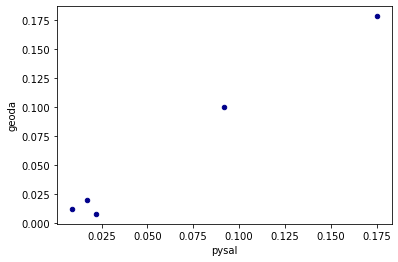

In [45]:
# Assess correlation between p-values
corrdf = pd.DataFrame(guerry_results.p_sim, guerry.PP_VAL_MV).reset_index()
corrdf.columns = ['pysal', 'geoda']
print("The correlation between the two sets of p-values is", corrdf['pysal'].corr(corrdf['geoda']))

corrdf.plot.scatter(x='pysal',
                    y='geoda',
                    c='DarkBlue')

Matching the GeoDa MV guerry example